In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV        # feature selection
from sklearn.linear_model import LogisticRegression  # models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV #parameter search
from sklearn.model_selection import train_test_split # oversampling and splitting data
from sklearn.preprocessing import MinMaxScaler   # scaling the data
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE 
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score           #metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import export_graphviz      # pretty plots
from subprocess import call
from IPython.display import Image
from PIL import Image
import warnings

#set random seed
np.random.seed(8)

warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = 933120000

# logistic regression - warm_start?
# random forest - boot strap? max depth? warm_start? 
# extra trees - boot strap? max depth? warm_start? 
# MLP - warm_start?
# 

# BRYN stuff
# grid search thru cv folds and num of features
# confidence interval for CV - get how andrew did his
# true positive and false negative - check?
# put SMOTE examples in training set - CHECK

# run the model with less features to try to get rid of overfitting!!!!!!!!!!!!
# read about the features again and look over the paper

In [3]:
full_data = pd.read_csv('csv/all_feats_all_tasks_non_slimmed.csv')
speech_col_names = [x for x in list(full_data.columns) if 'vad' in x]
speech_col_names = speech_col_names + ['childid']
speech_ds = full_data[speech_col_names]
bubbles_col_names = [y for y in list(full_data.columns) if 'bubbles' in y]
bubbles_col_names = bubbles_col_names + ['childid']
bubbles_ds = full_data[bubbles_col_names] # dataframe of all bubbles features
appr_col_names = [z for z in list(full_data.columns) if 'list' in z]
appr_col_names = appr_col_names + ['childid']
appr_ds = full_data[appr_col_names] # dataframe of all approach features 
speech_ds = speech_ds.set_index('childid')
bubbles_ds = bubbles_ds.set_index('childid')
appr_ds = appr_ds.set_index('childid')
full_data = full_data.set_index('childid')

kiddos = pd.read_csv('csv/target_information.csv')
kiddos['adhd_count'] = kiddos['adhddxever']>0
kiddos.adhd_count = kiddos.adhd_count.replace({True: 1, False: 0})

dep_or_anx = []
for i in range(84):
    if kiddos['anxdxever'][i] >0 or kiddos['depdxever'][i] >0:
        dep_or_anx.append(1)
    else:
        dep_or_anx.append(0)
kiddos['dep_anx'] = dep_or_anx


col_names = ['childid','depdxever','anxdxever','adhd_count','dep_anx']
kiddos_ds = kiddos[col_names]
kiddos_ds = kiddos_ds.set_index('childid')
full_speech_ds = pd.concat([speech_ds,kiddos_ds],axis = 1)
full_bubbles_ds = pd.concat([bubbles_ds,kiddos_ds],axis = 1) 
full_appr_ds = pd.concat([appr_ds,kiddos_ds],axis = 1) 
full_ds = pd.concat([full_data,kiddos_ds],axis = 1) 

# training = full_ds.iloc[:,:-3]
# print(list(training))
kiddos
# training
# full_data = full_data.iloc[:,1:]
# full_data

,Unnamed: 0,childid,Sex,AgeMonths,AgeYears,depdxever,anxdxever,adhddxever,depsxtotpres,anxsxtotpres,adhdsxtot,sx_tot,adhd_general,depdxtypes,anxdxtypes,adhd_count,dep_anx
0,0,101,Male,51,4,0,0,0,0,0,0,0,0,NaN,NaN,0,0
1,1,102,Female,92,7,1,1,0,3,5,0,8,0,NOS,NaN,0,1
2,2,103,Female,64,5,0,1,4,1,10,4,15,1,NaN,GAD,1,1
3,3,106,Male,79,6,0,1,0,0,4,0,4,0,NaN,separation anxiety disorder,0,1
4,4,107,Male,80,6,0,0,0,0,0,0,0,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,95,Male,107,8,0,0,0,0,5,0,5,0,NaN,NaN,0,0
80,80,10,Male,105,8,0,1,2,0,5,5,10,1,NaN,SAD Specific Phobia,1,1
81,81,140,Male,49,4,0,0,0,0,0,6,6,0,NaN,NaN,0,0
82,82,22,Female,94,7,1,1,1,12,11,8,31,1,dysthymia-secondary type,SADpast GAD current and past.,1,1


In [3]:
def oversampling(training:pd.DataFrame, target: pd.DataFrame): 
    ros = SMOTE() 
    X_res, y_res = ros.fit_resample(training, target)
    X_res_scaled = MinMaxScaler().fit_transform(X_res)
    X_res = pd.DataFrame(X_res_scaled,columns = X_res.columns, index = X_res.index)
    return X_res, y_res

def feature_selection(model, X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, num_feats: int, cv: int):
    selector = RFECV(model,step = 2, cv = cv, 
                     scoring ='recall')
    selector = selector.fit(X_train, y_train)
#     order = selector.ranking_
    order = selector.get_feature_names_out(X_train.columns)
    dep_feats = []
    for i in order:
        dep_feats.append(i)
    if len(dep_feats) > num_feats:
        cols = dep_feats[:num_feats]
    else:
        cols = dep_feats
#     print(cols)
    training = X_train[cols]
    test = X_test[cols]
    return training, test

def split_and_fit(model, X_train: pd.DataFrame, y_train: pd.DataFrame, num_split: int):
    for i in range(num_split):
        X_train,y_train = oversampling(X_train,y_train)
        X_train_run, X_train_out , y_train_run, y_train_out = train_test_split(X_train,y_train)
        model.fit(X_train_run,y_train_run)
    return model

def searchin(mod, cv_grid: dict,X_train: pd.DataFrame, y_train: pd.DataFrame, cv: int):
    grid_clf = GridSearchCV(estimator=mod, 
                                param_grid=cv_grid,
                                scoring="accuracy",
                                cv=cv,
                           )
    grid_clf.fit(X_train.values, y_train.values)
    best_mod = grid_clf.best_estimator_
    best_mod.fit(X_train.values, y_train.values)
    if 'SVC' in str(mod):
        best_mod = mod.fit(X_train.values, y_train.values)
    print(best_mod)
    return best_mod

def metrics(mod,X_test: pd.DataFrame,y_test: pd.DataFrame, mod_str:str, sx:str):
    
    mod_sx_str = str(mod_str[:-2]+'_'+sx).lower()
    preds = mod.predict(X_test)
    probs = mod.predict_proba(X_test)
    
    acc = accuracy_score(y_true= y_test, y_pred= preds)
    print('Accuracy: ', acc)
    
    roc = roc_auc_score(y_test, probs[:,1]) 
    print('ROC AUC: ', roc)
    
#     try: 
#         importances = mod.feature_importances_
#         for feature, importance in zip(X_test.columns, importances):
#             print(feature, importance)
#     except AttributeError:
#         print()
    
    try:
        estimator = mod.estimators_[1]

        export_graphviz(estimator, out_file= mod_sx_str+'.dot', 
                        feature_names = X_test.columns,
                        class_names = ['0','1'],
                        rounded = True, proportion = False, 
                        precision = 2, filled = True)

        call(['dot', '-Tpng', mod_sx_str+'.dot', '-o', mod_sx_str+'.png', '-Gdpi=600'])

#         Image(filename = mod_sx_str+'.png')
        pics = Image.open(mod_sx_str+'.png')
        pics = pics.resize((1080,1080),Image.ANTIALIAS)
        pics.save('pics/'+mod_sx_str+'.png', optimize=True, quality=95)  

    except AttributeError:
        print()
    fig, ax = plt.subplots(figsize=(8, 5))
    first, second = confusion_matrix(y_test, preds)
    tru_pos_rate = float(second[1]/(second[0]+second[1]))
    print('True Postive Rate: ', tru_pos_rate)
    fals_pos_rate = float(first[1]/(first[0]+first[1]))
    print('False Positive Rate: ', fals_pos_rate)
#     print(first)
#     print('----')
#     print(second)
    
    cmp = ConfusionMatrixDisplay(
            confusion_matrix(y_test, preds))

    cmp.plot(ax=ax)
    plt.savefig('Results/'+mod_sx_str+'.png')
    plt.show()
    return acc, roc, tru_pos_rate, fals_pos_rate

In [5]:
def multi_model(training: pd.DataFrame, target: pd.DataFrame, num_feats: int, cv:int, sx:str ):
    
    X_train , X_test , y_train , y_test = train_test_split(training, target, test_size=.3)
            
    X_train, y_train = oversampling(X_train,y_train) 
    
    acc_nums = []
    roc_nums = []
    tru_pos_nums = []
    fals_pos_nums = []
    
    cv_grid_lg = {
                "penalty": ["l2",'none'], #  'elasticnet','l1']
                'max_iter': np.arange(0, 10000,1000),
                'solver' : ['sag'], #,'liblinear' , 'saga']
            }
    cv_grid_rf = { 
                'n_estimators' : np.arange(50,150,10),
                'max_features' : ['log2','sqrt'], #,'auto'],
                'criterion' : ['entropy'],
                'max_depth': np.arange(4,20,2)
                }
    cv_grid_et = {
                'n_estimators' : np.arange(50,150,10),
                'max_features' : ['log2','sqrt'], #,'auto'],
                'criterion' : ['entropy'],
                'max_depth': np.arange(4,20,2)
                }

    cv_grid_mlp = {
                'hidden_layer_sizes': [(100,2), (100,3), (100,4), (100,5), (100,6)],
                'activation' : ['identity', 'logistic', 'tanh'], #, 'relu'],
                'solver' : ['sgd'], # adam],
                'learning_rate': ['adaptive'], # 'constant', 'invscaling']
                'max_iter' : np.arange(200,600,50),
                }
    cv_grid_svm = {
                'kernel' : ['rbf', 'sigmoid'],
                'degree' : np.arange(3,300), #go down
                }

    mod = LogisticRegression()
    lr_str = str(mod)
    dep_train_lg, dep_test_lg = feature_selection(mod,X_train,y_train,X_test,num_feats,cv)
    model = searchin(mod,cv_grid_lg,dep_train_lg,y_train,cv)
#     model = split_and_fit(model,X_train=dep_train_lg, y_train= y_train, num_split=10)
    lg_acc, lg_roc, lg_tru_pos,lg_fals_pos = metrics(model,dep_test_lg, y_test, lr_str, sx)
    acc_nums.append(lg_acc)
    roc_nums.append(lg_roc)
    tru_pos_nums.append(lg_tru_pos)
    fals_pos_nums.append(lg_fals_pos)
    
    mod = RandomForestClassifier()
    rf_str = str(mod)
    dep_train_rf, dep_test_rf = feature_selection(mod,X_train,y_train,X_test,num_feats,cv)
    model = searchin(mod,cv_grid_rf,dep_train_rf,y_train,cv)
#     model = split_and_fit(model, X_train= dep_train_rf, y_train=y_train,num_split=10)
    rf_acc, rf_roc, rf_tru_pos, rf_fals_pos= metrics(model,dep_test_rf,y_test, rf_str,sx)
    acc_nums.append(rf_acc)
    roc_nums.append(rf_roc)
    tru_pos_nums.append(rf_tru_pos)
    fals_pos_nums.append(rf_fals_pos)
    
    mod = ExtraTreesClassifier()
    et_str = str(mod)
    dep_train_et, dep_test_et = feature_selection(mod,X_train,y_train,X_test,num_feats,cv)
    model = searchin(mod,cv_grid_et,dep_train_et,y_train,cv)
#     model = split_and_fit(model,X_train= dep_train_et,y_train= y_train,num_split=10)
    et_acc, et_roc, et_tru_pos, et_fals_pos = metrics(model,dep_test_et, y_test, et_str, sx)
    acc_nums.append(et_acc)
    roc_nums.append(et_roc)
    tru_pos_nums.append(et_tru_pos)
    fals_pos_nums.append(et_fals_pos)
    
    mod = MLPClassifier(early_stopping = True)
    mlp_str = str(mod)
    # dep_train_nn, dep_test_nn = feature_selection(mod,X_train,y_train,X_test,30)
    model = searchin(mod,cv_grid_mlp,X_train,y_train,cv)
#     model = split_and_fit(model, X_train,y_train,num_split=10)
    nn_acc, nn_roc, nn_tru_pos, nn_fals_pos = metrics(model,X_test, y_test, mlp_str, sx)
    acc_nums.append(nn_acc)
    roc_nums.append(nn_roc)
    tru_pos_nums.append(nn_tru_pos)
    fals_pos_nums.append(nn_fals_pos)

    mod = SVC(probability = True)
    svm_str = str(mod)
#     dep_train_svm, dep_test_svm = feature_selection(mod,X_train,y_train,X_test,num_feats,cv)
    model = searchin(mod,cv_grid_svm,X_train,y_train,cv)
#     model = split_and_fit(model, X_train,y_train,num_split=10)
    svm_acc, svm_roc, svm_tru_pos, svm_fals_pos = metrics(mod,X_test, y_test,svm_str, sx)
    acc_nums.append(svm_acc)
    roc_nums.append(svm_roc)
    tru_pos_nums.append(svm_tru_pos)
    fals_pos_nums.append(svm_fals_pos)
    
    data = {sx+'_model_acc': acc_nums,
            sx+'_roc_auc': roc_nums,
            sx+'_tru_pos': tru_pos_nums,
            sx+'_fals_pos': fals_pos_nums}
    
    results = pd.DataFrame(index = ['logistic', 'random forest', 'extra trees', 'MLP NN', 'SVM'], data = data)
    
    return results

LogisticRegression(max_iter=1000, solver='sag')
Accuracy:  1.0
ROC AUC:  1.0

True Postive Rate:  1.0
False Positive Rate:  0.0


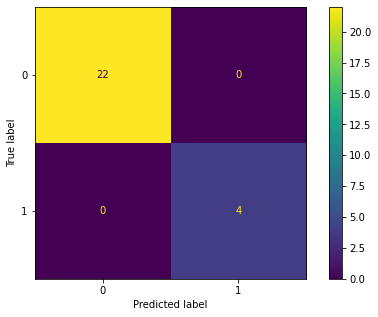

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       n_estimators=50)
Accuracy:  1.0
ROC AUC:  1.0
True Postive Rate:  1.0
False Positive Rate:  0.0


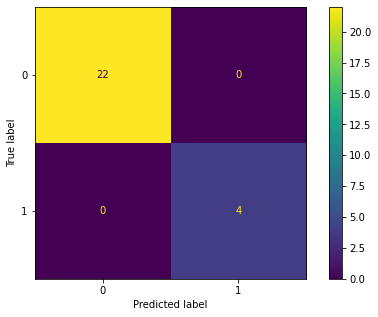

ExtraTreesClassifier(criterion='entropy', max_depth=4, max_features='log2',
                     n_estimators=50)
Accuracy:  1.0
ROC AUC:  1.0
True Postive Rate:  1.0
False Positive Rate:  0.0


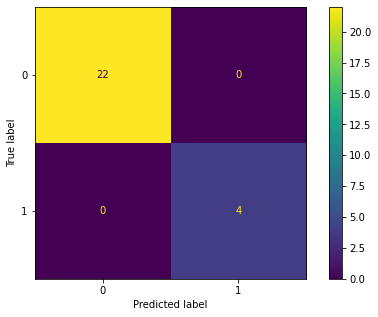

MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(100, 2), learning_rate='adaptive',
              max_iter=350, solver='sgd')
Accuracy:  0.15384615384615385
ROC AUC:  0.5

True Postive Rate:  1.0
False Positive Rate:  1.0


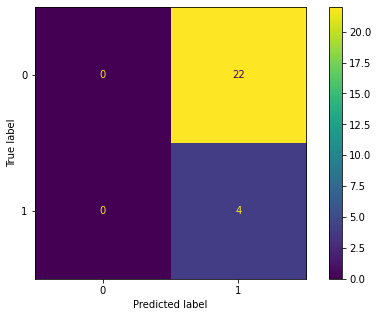

SVC(probability=True)
Accuracy:  0.8461538461538461
ROC AUC:  0.5

True Postive Rate:  0.0
False Positive Rate:  0.0


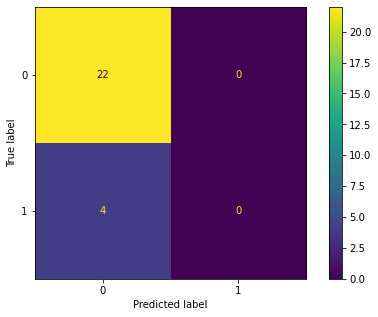

LogisticRegression(max_iter=1000, solver='sag')
Accuracy:  0.19230769230769232
ROC AUC:  0.5

True Postive Rate:  1.0
False Positive Rate:  1.0


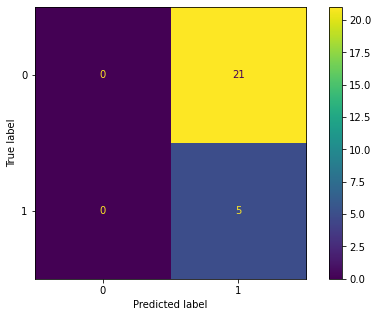

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       n_estimators=50)
Accuracy:  0.19230769230769232
ROC AUC:  0.4380952380952381
True Postive Rate:  1.0
False Positive Rate:  1.0


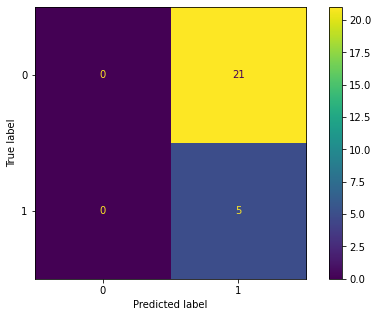

ExtraTreesClassifier(criterion='entropy', max_depth=12, max_features='log2',
                     n_estimators=70)
Accuracy:  0.19230769230769232
ROC AUC:  0.5190476190476191
True Postive Rate:  1.0
False Positive Rate:  1.0


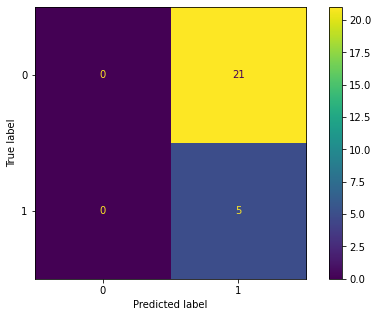

MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(100, 4), learning_rate='adaptive',
              max_iter=550, solver='sgd')
Accuracy:  0.8076923076923077
ROC AUC:  0.5

True Postive Rate:  0.0
False Positive Rate:  0.0


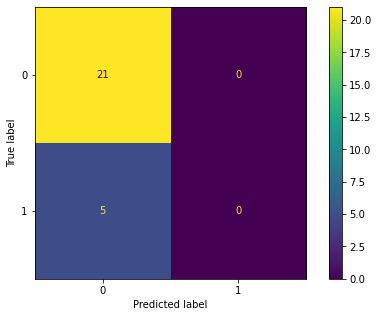

SVC(probability=True)
Accuracy:  0.8076923076923077
ROC AUC:  0.5

True Postive Rate:  0.0
False Positive Rate:  0.0


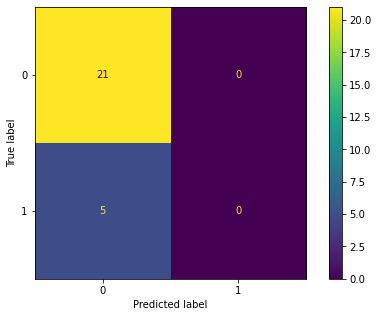

LogisticRegression(max_iter=1000, penalty='none', solver='sag')
Accuracy:  0.3076923076923077
ROC AUC:  0.5

True Postive Rate:  1.0
False Positive Rate:  1.0


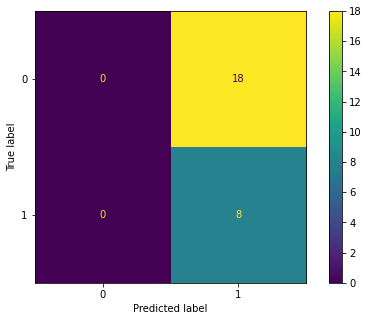

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       n_estimators=70)
Accuracy:  0.3076923076923077
ROC AUC:  0.3263888888888889
True Postive Rate:  1.0
False Positive Rate:  1.0


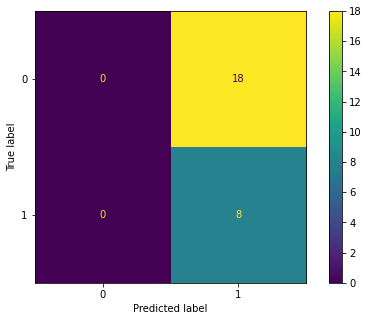

ExtraTreesClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                     n_estimators=50)
Accuracy:  0.3076923076923077
ROC AUC:  0.18402777777777776
True Postive Rate:  1.0
False Positive Rate:  1.0


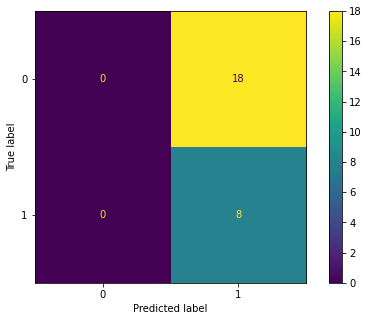

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(100, 5), learning_rate='adaptive',
              max_iter=250, solver='sgd')
Accuracy:  0.3076923076923077
ROC AUC:  0.6180555555555556

True Postive Rate:  1.0
False Positive Rate:  1.0


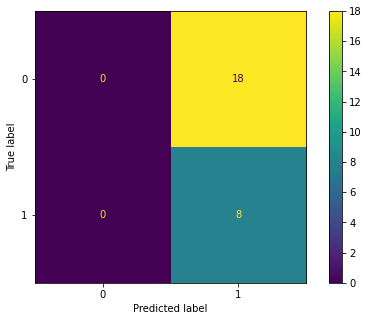

SVC(probability=True)
Accuracy:  0.6923076923076923
ROC AUC:  0.5

True Postive Rate:  0.0
False Positive Rate:  0.0


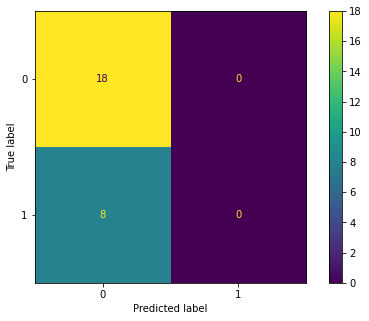

LogisticRegression(max_iter=1000, solver='sag')
Accuracy:  0.3076923076923077
ROC AUC:  0.4652777777777777

True Postive Rate:  1.0
False Positive Rate:  1.0


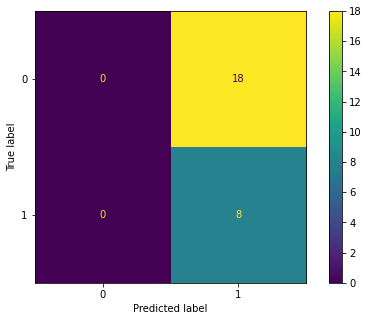

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       n_estimators=140)
Accuracy:  0.3076923076923077
ROC AUC:  0.4305555555555556
True Postive Rate:  1.0
False Positive Rate:  1.0


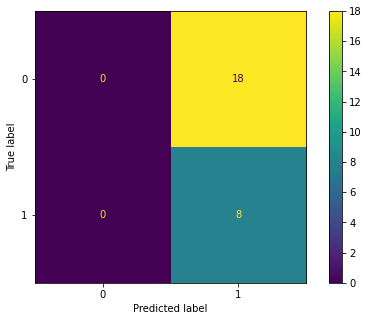

ExtraTreesClassifier(criterion='entropy', max_depth=18, max_features='log2',
                     n_estimators=60)
Accuracy:  0.3076923076923077
ROC AUC:  0.39236111111111116
True Postive Rate:  1.0
False Positive Rate:  1.0


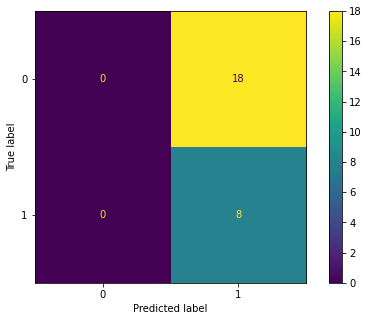

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(100, 3), learning_rate='adaptive',
              max_iter=450, solver='sgd')
Accuracy:  0.3076923076923077
ROC AUC:  0.49652777777777773

True Postive Rate:  1.0
False Positive Rate:  1.0


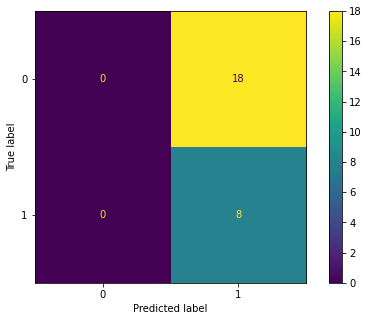

SVC(probability=True)
Accuracy:  0.6923076923076923
ROC AUC:  0.5

True Postive Rate:  0.0
False Positive Rate:  0.0


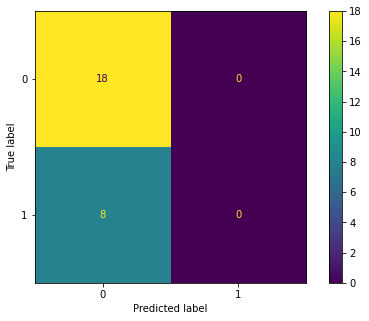

Execution time in seconds: 2874.641896724701


In [6]:
import time
startTime = time.time()
training = full_bubbles_ds.iloc[:,:-3]

target = full_bubbles_ds['depdxever']
dep_results = multi_model(training,target,15,10,'dep')
target = full_bubbles_ds['anxdxever']
anx_results = multi_model(training,target,15,10,'anx')
target = full_bubbles_ds['adhd_count']
adhd_results = multi_model(training,target,15,10,'adhd')
target = full_bubbles_ds['dep_anx']
dep_anx_results = multi_model(training,target,15,10,'dep_anx')

master = pd.concat([dep_results,anx_results,adhd_results,dep_anx_results],axis = 1)
master

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,1.000000,1.0,1.0,0.0,0.192308,0.500000,1.0,1.0,0.307692,0.500000,1.0,1.0,0.307692,0.465278,1.0,1.0
random forest,1.000000,1.0,1.0,0.0,0.192308,0.438095,1.0,1.0,0.307692,0.326389,1.0,1.0,0.307692,0.430556,1.0,1.0
extra trees,1.000000,1.0,1.0,0.0,0.192308,0.519048,1.0,1.0,0.307692,0.184028,1.0,1.0,0.307692,0.392361,1.0,1.0
MLP NN,0.153846,0.5,1.0,1.0,0.807692,0.500000,0.0,0.0,0.307692,0.618056,1.0,1.0,0.307692,0.496528,1.0,1.0
SVM,0.846154,0.5,0.0,0.0,0.807692,0.500000,0.0,0.0,0.692308,0.500000,0.0,0.0,0.692308,0.500000,0.0,0.0


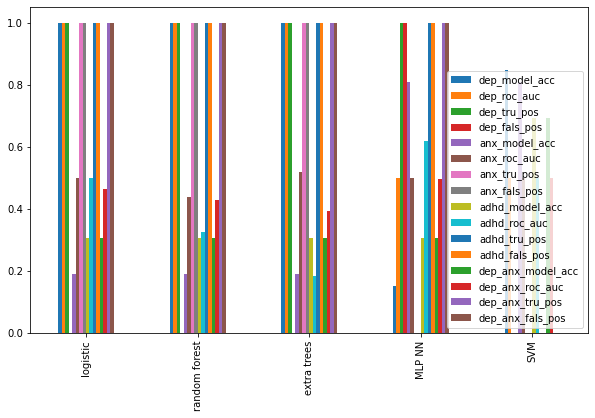

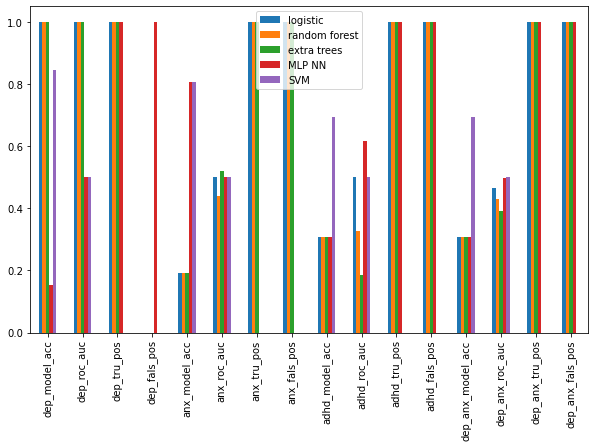

In [7]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master
# dep & adhd & anx cv = 10, 15 features max,
# over sampled - SMOTE - train 
# BRYNS STUFF - NONE
# BUBBLES


,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,0.923077,0.500000,0.0,0.0,0.692308,0.601504,0.428571,0.210526,0.769231,0.500000,0.000000,0.00,0.538462,0.586466,0.714286,0.526316
random forest,1.000000,1.000000,1.0,0.0,0.692308,0.661654,0.571429,0.263158,0.653846,0.533333,0.333333,0.25,0.615385,0.620301,0.714286,0.421053
extra trees,1.000000,1.000000,1.0,0.0,0.730769,0.624060,0.428571,0.157895,0.769231,0.725000,0.166667,0.05,0.615385,0.781955,0.714286,0.421053
MLP NN,0.923077,0.739583,0.0,0.0,0.769231,0.571429,0.142857,0.000000,0.769231,0.487500,0.000000,0.00,0.269231,0.353383,1.000000,1.000000
SVM,0.923077,0.479167,0.0,0.0,0.730769,0.578947,0.000000,0.000000,0.769231,0.575000,0.000000,0.00,0.730769,0.646617,0.000000,0.000000


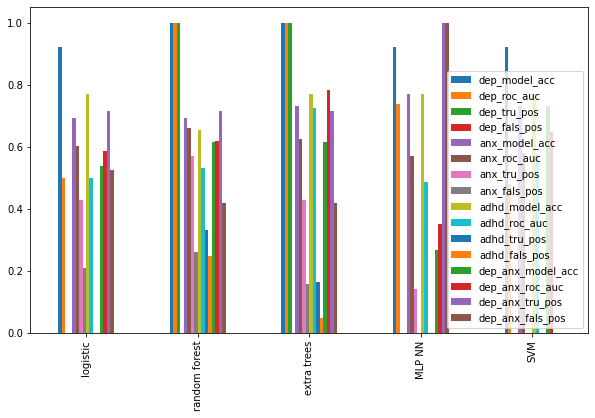

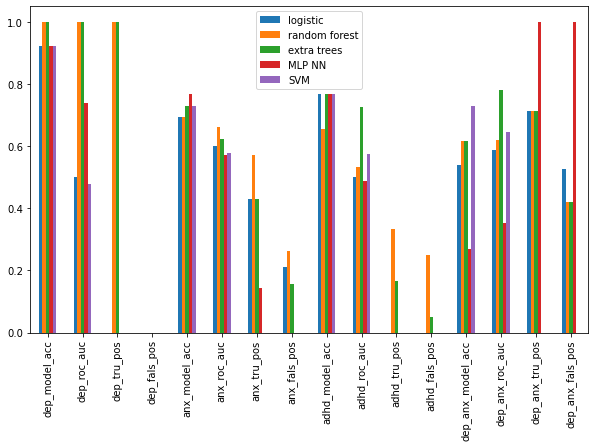

In [37]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master
# dep & adhd & anx cv = 10, 20 features max,
# over sampled - NONE - train 
# BRYNS STUFF - NONE
# BUBBLES
# random forest anx, extra trees dep_anx

,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,0.576923,0.636364,0.181818,0.133333,0.576923,0.503030,0.181818,0.133333
random forest,0.576923,0.754545,0.363636,0.266667,0.576923,0.560606,0.272727,0.200000
extra trees,0.576923,0.657576,0.272727,0.200000,0.692308,0.657576,0.545455,0.200000
MLP NN,0.576923,0.618182,0.272727,0.200000,0.576923,0.339394,0.000000,0.000000
SVM,0.576923,0.581818,0.000000,0.000000,0.576923,0.551515,0.000000,0.000000


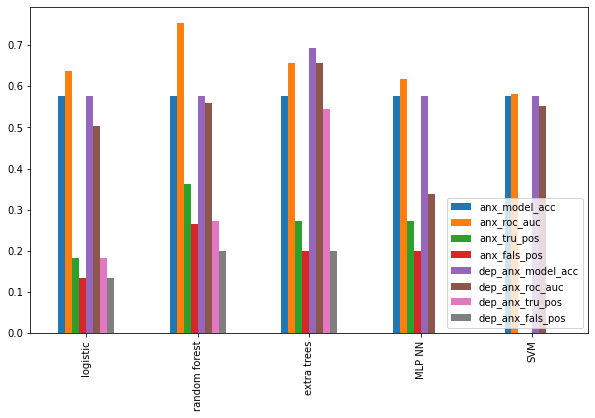

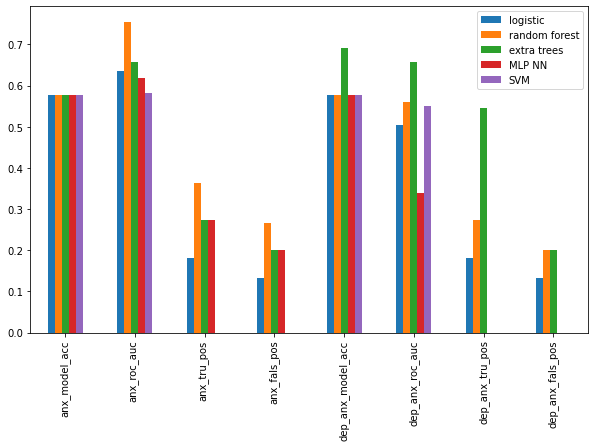

In [23]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master
# dep & adhd & anx cv = 10, 15 features max,
# over sampled - NONE - train 
# BRYNS STUFF - NONE
# FULL DATA SET - dep_anx


,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,0.846154,0.500,0.0,0.0,0.461538,0.48125,0.0,0.2500,0.653846,0.159420,0.000000,0.260870,0.384615,0.446429,0.357143,0.583333
random forest,1.000000,1.000,1.0,0.0,0.576923,0.60000,0.1,0.1250,0.884615,0.637681,0.666667,0.086957,0.538462,0.550595,0.285714,0.166667
extra trees,1.000000,1.000,1.0,0.0,0.576923,0.61875,0.4,0.3125,0.884615,0.739130,0.000000,0.000000,0.653846,0.648810,0.357143,0.000000
MLP NN,0.846154,0.500,0.0,0.0,0.615385,0.50000,0.0,0.0000,0.884615,0.565217,0.000000,0.000000,0.461538,0.500000,0.000000,0.000000
SVM,0.846154,0.375,0.0,0.0,0.615385,0.43750,0.0,0.0000,0.884615,0.347826,0.000000,0.000000,0.461538,0.494048,0.000000,0.000000


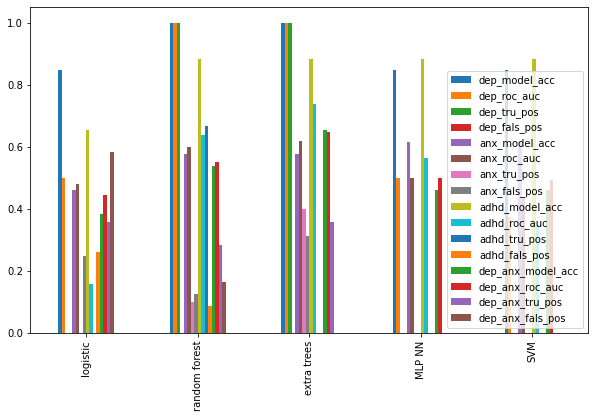

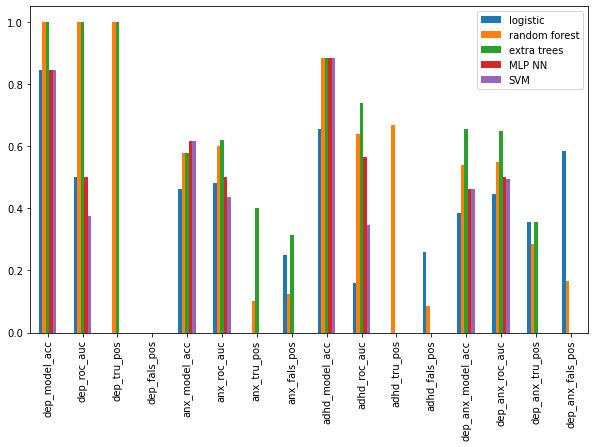

In [9]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master
# dep & adhd & anx cv = 10, 20 features max,
# over sampled - NONE - train 
# BRYNS STUFF - NONE
# SPEECH 
# random forest ADHD

,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,0.923077,0.500000,0.0,0.0,0.576923,0.509804,0.555556,0.411765,0.884615,0.500000,0.0,0.000000,0.500000,0.452381,0.285714,0.250000
random forest,1.000000,1.000000,1.0,0.0,0.461538,0.470588,0.111111,0.352941,0.846154,0.615942,0.0,0.043478,0.500000,0.562500,0.357143,0.333333
extra trees,1.000000,1.000000,1.0,0.0,0.576923,0.503268,0.111111,0.176471,0.846154,0.659420,0.0,0.043478,0.500000,0.604167,0.428571,0.416667
MLP NN,0.923077,0.500000,0.0,0.0,0.653846,0.500000,0.000000,0.000000,0.884615,0.500000,0.0,0.000000,0.461538,0.351190,0.000000,0.000000
SVM,0.923077,0.479167,0.0,0.0,0.653846,0.483660,0.000000,0.000000,0.884615,0.333333,0.0,0.000000,0.461538,0.452381,0.000000,0.000000


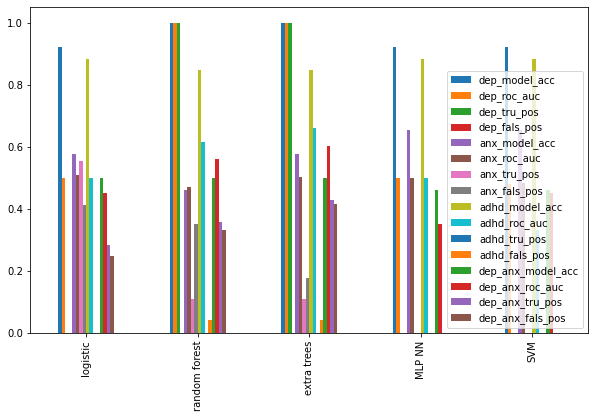

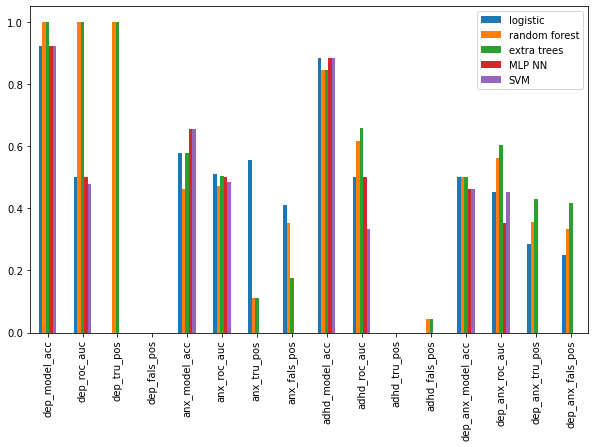

In [18]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd & anx cv = 10, 30 features max, over sampled - NONE, minmax scalar, not fitting model thru byn stuff
# SPEECH just to test


,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,1.000000,1.000000,1.000000,0.00000,0.461538,0.418750,0.1,0.3125,0.423077,0.568182,0.5,0.590909,0.423077,0.390533,0.307692,0.461538
random forest,1.000000,1.000000,1.000000,0.00000,0.576923,0.353125,0.0,0.0625,0.384615,0.568182,1.0,0.727273,0.423077,0.500000,0.307692,0.461538
extra trees,1.000000,1.000000,1.000000,0.00000,0.461538,0.415625,0.1,0.3125,0.846154,0.670455,0.0,0.000000,0.423077,0.476331,0.538462,0.692308
MLP NN,0.307692,0.376812,0.666667,0.73913,0.615385,0.500000,0.0,0.0000,0.846154,0.500000,0.0,0.000000,0.423077,0.431953,0.615385,0.769231
SVM,0.884615,0.500000,0.000000,0.00000,0.615385,0.500000,0.0,0.0000,0.846154,0.500000,0.0,0.000000,0.500000,0.500000,0.000000,0.000000


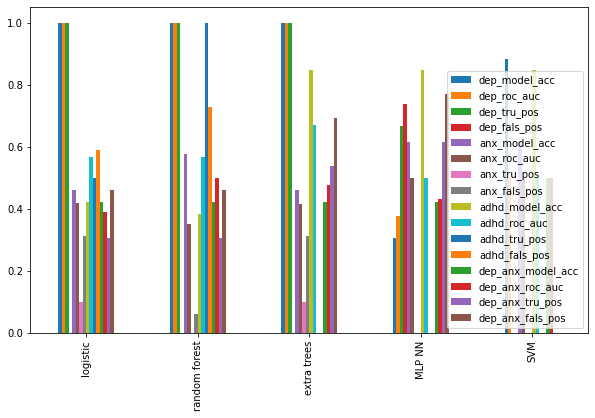

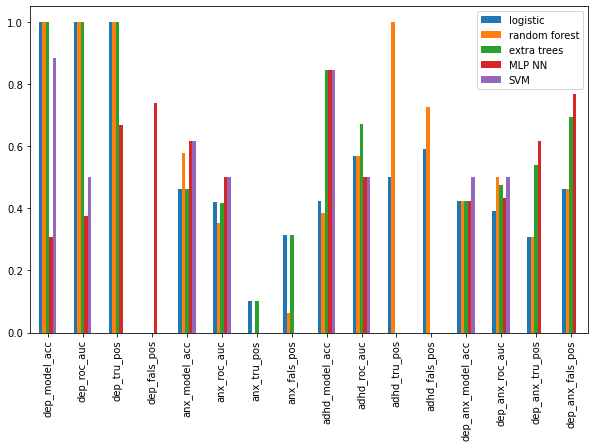

In [13]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd & anx cv = 2, 1 features max, over sampled - SMOTE, minmax scalar, not fitting model thru byn stuff
# SPEECH just to test


,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,1.000000,1.0,1.0,0.0,0.461538,0.500000,1.000000,1.000000,0.269231,0.500000,1.000000,1.000000,0.576923,0.484848,0.0,0.000000
random forest,1.000000,1.0,1.0,0.0,0.461538,0.473214,0.916667,0.928571,0.730769,0.601504,0.000000,0.000000,0.576923,0.400000,0.0,0.000000
extra trees,1.000000,1.0,1.0,0.0,0.461538,0.654762,1.000000,1.000000,0.730769,0.545113,0.000000,0.000000,0.576923,0.415152,0.0,0.000000
MLP NN,0.115385,0.5,1.0,1.0,0.538462,0.500000,0.000000,0.000000,0.653846,0.665414,0.714286,0.368421,0.500000,0.357576,0.0,0.133333
SVM,0.884615,0.5,0.0,0.0,0.538462,0.500000,0.000000,0.000000,0.730769,0.500000,0.000000,0.000000,0.576923,0.500000,0.0,0.000000


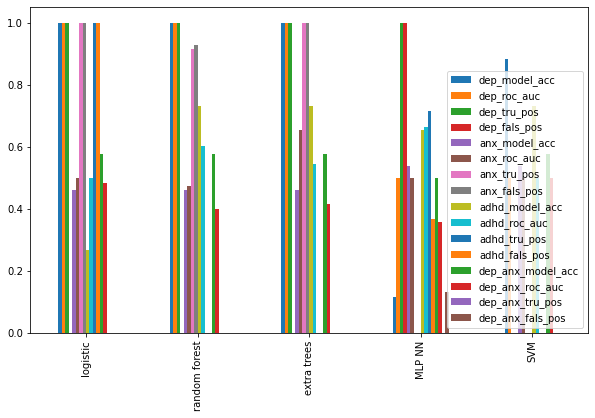

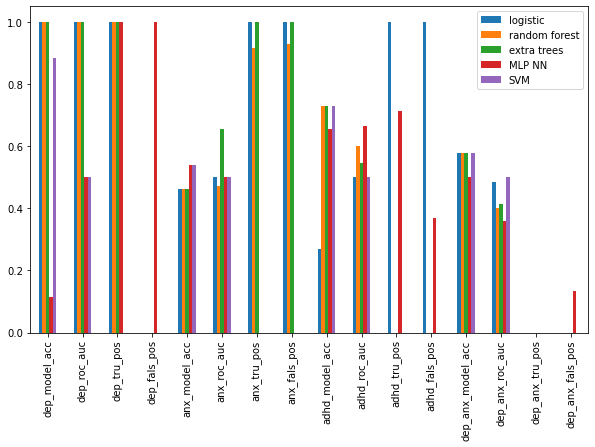

In [6]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd & anx cv = 10, 30 features max, over sampled - SMOTE, minmax scalar, not fitting model thru byn stuff
# SPEECH just to test
# MLP ADHD looks ok

,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,1.000000,1.000000,1.00,0.000000,0.500000,0.563910,0.000000,0.315789,0.884615,0.507246,0.0,0.0,0.538462,0.642424,0.090909,0.133333
random forest,1.000000,1.000000,1.00,0.000000,0.615385,0.597744,0.428571,0.315789,0.884615,0.644928,0.0,0.0,0.615385,0.612121,0.090909,0.000000
extra trees,1.000000,1.000000,1.00,0.000000,0.576923,0.481203,0.428571,0.368421,0.884615,0.210145,0.0,0.0,0.576923,0.636364,0.636364,0.466667
MLP NN,0.269231,0.477273,0.75,0.818182,0.423077,0.428571,0.428571,0.578947,0.115385,0.500000,1.0,1.0,0.576923,0.500000,0.000000,0.000000
SVM,0.846154,0.500000,0.00,0.000000,0.730769,0.500000,0.000000,0.000000,0.884615,0.500000,0.0,0.0,0.576923,0.500000,0.000000,0.000000


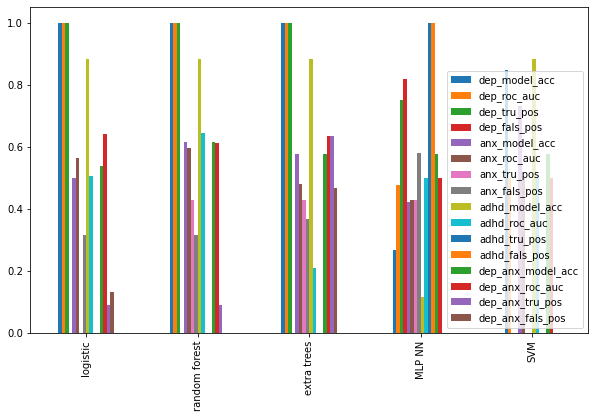

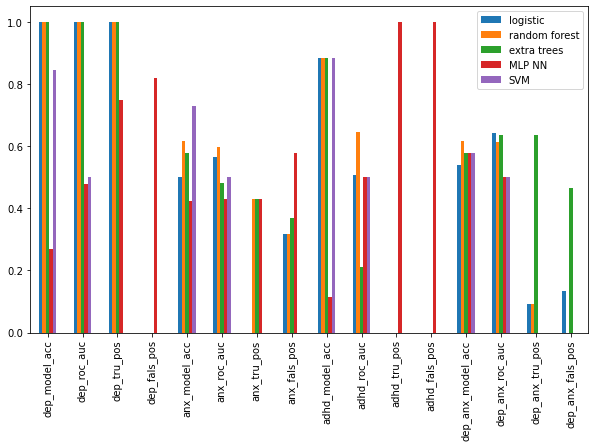

In [46]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd & anx cv = 3, 30 features max, over sampled - NONE, minmax scalar, not fitting model thru byn stuff
# SPEECH just to test

,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos
logistic,0.923077,0.500000,0.0,0.0,0.615385,0.430556,0.125,0.166667,0.730769,0.500000,0.000000,0.000000,0.538462,0.61875,0.5,0.4375
random forest,1.000000,1.000000,1.0,0.0,0.538462,0.319444,0.125,0.277778,0.769231,0.469925,0.285714,0.052632,0.500000,0.45625,0.3,0.3750
extra trees,1.000000,1.000000,1.0,0.0,0.692308,0.416667,0.250,0.111111,0.730769,0.721805,0.142857,0.052632,0.730769,0.71875,0.4,0.0625
MLP NN,0.923077,0.500000,0.0,0.0,0.500000,0.534722,0.375,0.444444,0.730769,0.500000,0.000000,0.000000,0.615385,0.43125,0.2,0.1250
SVM,0.923077,0.520833,0.0,0.0,0.653846,0.625000,0.000,0.055556,0.730769,0.481203,0.000000,0.000000,0.615385,0.45000,0.0,0.0000


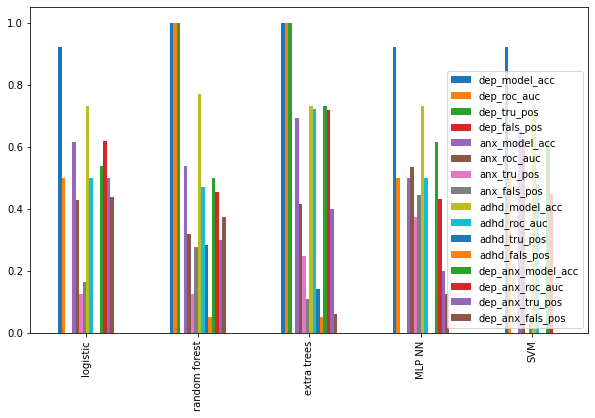

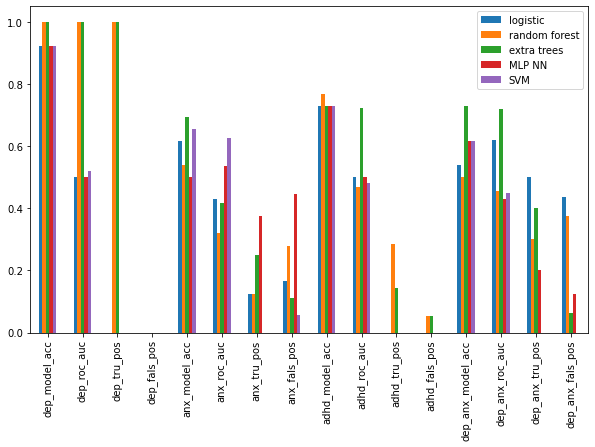

In [43]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd & anx cv = 3, 10 features max, over sampled - NONE, minmax scalar, not fitting model thru byn stuff
# SPEECH just to test

,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos:,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos:,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos:,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos:
logistic,0.846154,0.5,0.0,0.0,0.346154,0.500000,1.000000,1.000000,0.769231,0.500000,0.000000,0.0,0.500000,0.490909,0.272727,0.333333
random forest,1.000000,1.0,1.0,0.0,0.538462,0.522876,0.000000,0.176471,0.769231,0.283333,0.000000,0.0,0.423077,0.451515,0.818182,0.866667
extra trees,1.000000,1.0,1.0,0.0,0.346154,0.447712,1.000000,1.000000,0.423077,0.591667,0.833333,0.7,0.461538,0.457576,0.272727,0.400000
MLP NN,0.846154,0.5,0.0,0.0,0.346154,0.457516,0.888889,0.941176,0.653846,0.562500,0.500000,0.3,0.423077,0.339394,0.818182,0.866667
SVM,0.846154,0.5,0.0,0.0,0.653846,0.500000,0.000000,0.000000,0.769231,0.500000,0.000000,0.0,0.576923,0.500000,0.000000,0.000000


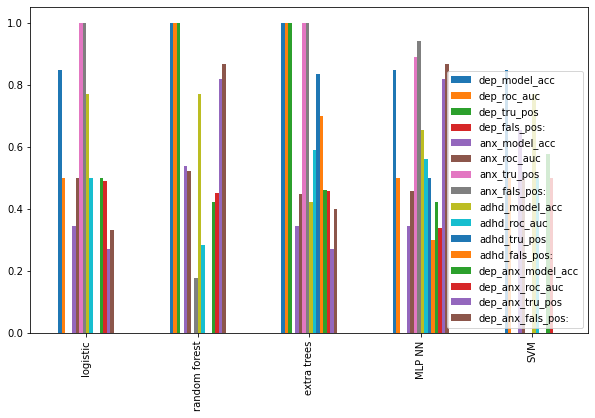

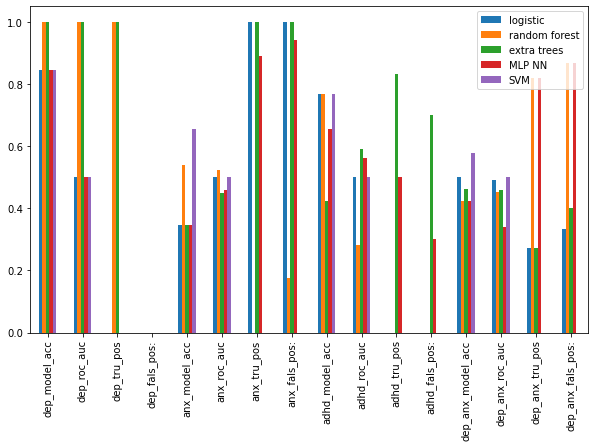

In [36]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd & anx cv = 3, 10 features max, over sampled - SMOTE, minmax scalar, BRYNS STUFF 
# SPEECH just to test

,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos:,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos:,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos:,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos:
logistic,0.807692,0.500000,0.0,1.0,0.538462,0.500000,0.000000,1.000000,0.730769,0.500000,0.0,1.0,0.653846,0.500000,0.000000,1.000000
random forest,1.000000,1.000000,1.0,1.0,0.615385,0.505952,0.166667,1.000000,0.730769,0.669173,0.0,1.0,0.538462,0.424837,0.000000,0.823529
extra trees,1.000000,1.000000,1.0,1.0,0.576923,0.464286,0.250000,0.857143,0.730769,0.759398,0.0,1.0,0.500000,0.424837,0.222222,0.647059
MLP NN,0.807692,0.500000,0.0,1.0,0.653846,0.726190,0.416667,0.857143,0.730769,0.500000,0.0,1.0,0.692308,0.588235,0.222222,0.941176
SVM,0.807692,0.533333,0.0,1.0,0.538462,0.369048,0.000000,1.000000,0.730769,0.609023,0.0,1.0,0.538462,0.594771,0.111111,0.764706


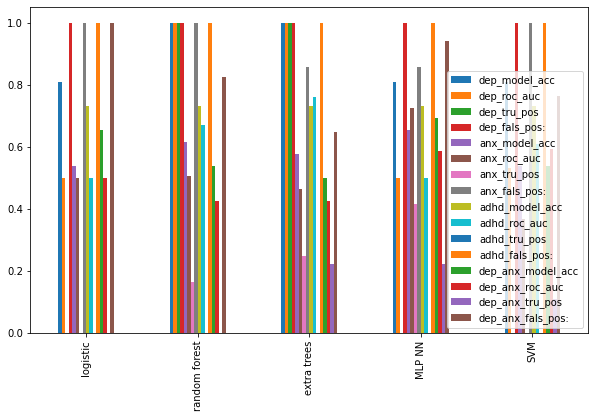

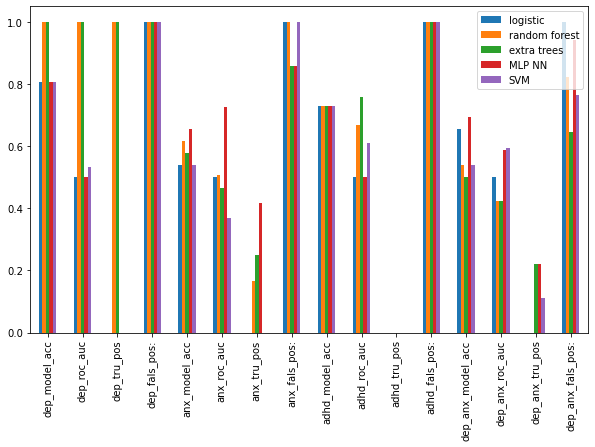

In [8]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd & anx cv = 12, 12 features max, over sampled - NONE, minmax scalar, BRYNS STUFF 
# SPEECH just to test

,dep_model_acc,dep_roc_auc,dep_tru_pos,dep_fals_pos:,anx_model_acc,anx_roc_auc,anx_tru_pos,anx_fals_pos:,adhd_model_acc,adhd_roc_auc,adhd_tru_pos,adhd_fals_pos:,dep_anx_model_acc,dep_anx_roc_auc,dep_anx_tru_pos,dep_anx_fals_pos:
logistic,0.884615,0.500000,0.0,1.0,0.769231,0.500000,0.000000,1.0,0.769231,0.500000,0.000000,1.00,0.538462,0.500000,0.000000,1.000000
random forest,1.000000,1.000000,1.0,1.0,0.500000,0.341667,0.166667,0.6,0.807692,0.350000,0.166667,1.00,0.461538,0.523810,0.416667,0.500000
extra trees,1.000000,1.000000,1.0,1.0,0.692308,0.575000,0.333333,0.8,0.769231,0.566667,0.166667,0.95,0.615385,0.619048,0.666667,0.571429
MLP NN,0.884615,0.500000,0.0,1.0,0.769231,0.191667,0.000000,1.0,0.769231,0.500000,0.000000,1.00,0.461538,0.345238,0.166667,0.714286
SVM,0.884615,0.536232,0.0,1.0,0.769231,0.633333,0.000000,1.0,0.769231,0.591667,0.000000,1.00,0.538462,0.476190,0.000000,1.000000


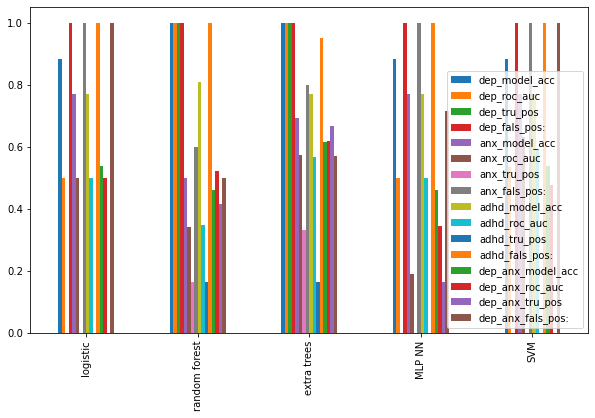

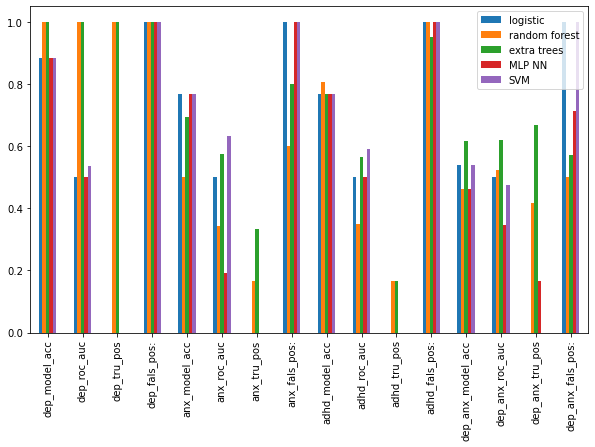

In [6]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd & anx cv = 3, 20 features max, over sampled - NONE, minmax scalar, BRYNS STUFF 
# SPEECH just to test

,dep_model_acc,dep_roc_auc,dep_tru_pos,anx_model_acc,anx_roc_auc,anx_tru_pos,adhd_model_acc,adhd_roc_auc,adhd_tru_pos
logistic,0.846154,0.386364,0.846154,0.423077,0.440476,0.461538,0.115385,0.652174,NaN
random forest,0.153846,0.545455,NaN,0.538462,0.610119,0.583333,0.884615,0.275362,0.884615
extra trees,0.153846,0.522727,NaN,0.461538,0.607143,0.500000,0.846154,0.630435,0.880000
MLP NN,0.615385,0.318182,0.800000,0.576923,0.607143,1.000000,0.846154,0.507246,0.880000
SVM,0.846154,0.500000,0.846154,0.538462,0.500000,0.538462,0.884615,0.500000,0.884615


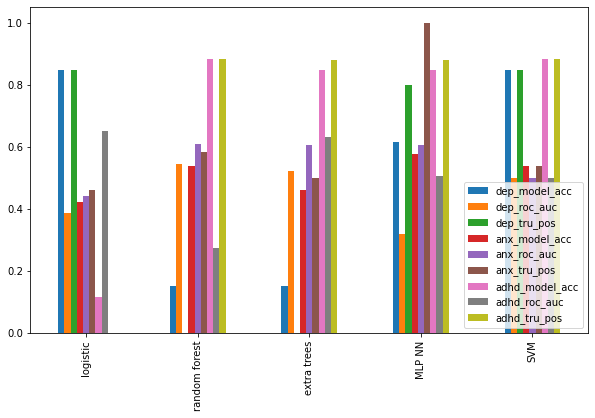

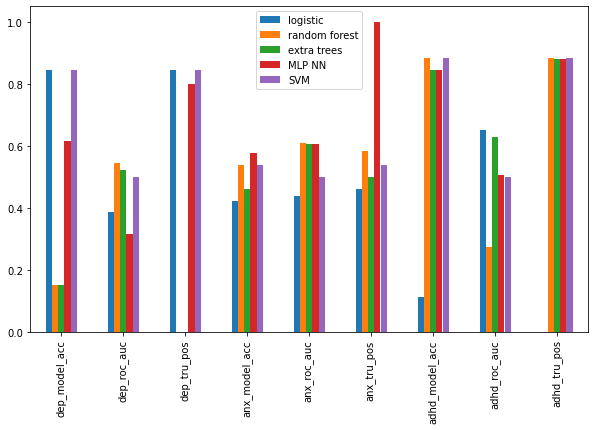

In [46]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd cv  = 12, anx cv = 7, 20 features max, over sampled - SMOTE, minmax scalar, BRYNS STUFF 
# SPEECH